# 识别上市公司财务舞弊行为---基于机器学习模型（LightGBM和XGBoost）

## 背景

近十几年来，上市公司财务舞弊事件层出不穷，严重损害了投资者利益，影响了资本市场的良性发展。即便是证监会等权威监督机构，识别出来的舞弊事件也很有限，而且普遍存在滞后性。本文运用新兴机器学习的方法对公司财务舞弊进行了预测。具体地，选取财务比率指标与文本信息、内部控制等非财务指标作为初始输入变量，采用欠采样方法处理训练集样本非平衡的问题，选择轻量梯度提升机算法对公司是否发生舞弊建立分类模型

## 分析思路

**准备变量数据 - 放入两种机器学习模型 - 调整参数 - 比对相关指标 - 选择最优模型**

## 变量选择依据

本项目参考刘云菁等（2022）基于新兴机器学习算法对于上市公司财务舞弊识别模型设计及其应用研究，选择流转税率（F032501B），综合税率A（F032601B），第一大股东持股比例（LargestHolderRate）,普通股获利率A(F101201B),内部控制指数(innercontrol)，销售费用增长率(F081901B),财务费用率(F051901B),管理费用率(F051801B),流动负债比率(F031501A),管理层讨论与分析语气(ManagementTone)，文本复杂度（Fog）等十一个变量。

**值得注意的是，由于没有内部控制指数数据库访问权限，本项目基于公司独立董事占比以及独立董事在董事会的参与程度构造了一个全新的内控指数。**

此外，基于符号亮等人（2021）对于年报语调的研究，**本项目扩大了语调分析的内容范围，从管理层内容转向整个年报内容的分析**，以期获得更全面的分析。

对于语调选择，George(2016)的研究表明，盈利操纵程度较低和杠杆率较高的公司，其悲观语言的总比例较高。相比之下，高增长公司表现出的悲观情绪较少。悲观程度较高的公司即使遇到坏消息或低现金流，也会表现出较高的保守性。**使用悲观语言的公司往往表现出更强的公司治理**。使用悲观语言与预测准确性和分析师覆盖率呈正相关。年报往往更加悲观，以引导分析师下调预期并达到目标收益。达到或刚刚超过分析师预测的公司往往使用较少的悲观语言。另一方面，它们可能会使用悲观的语言，以减少市场对业绩不佳的负面反应。**因此，本项目计算悲观语调比例作为管理层讨论与分析语气变量的值。**

最后，de Souza et al.(2018)的研究表明，根据管理混乱理论（management obfuscation hypothesis），负收益的公司拥有可读性更低的财务报告，因为管理者倾向于用复杂的语言来掩盖不良表现，从而造成了信息混乱（information obfuscation）（Li 2008 cited João et al. 2018）。Bloomfield （2008 cited João et al. 2018 ）给出了两个额外的合理解释。他认为负收益使得管理者倾向于对利益相关人去提供更多的解释，从而减少负收益带来的负面影响。此外，基于会计的谨慎性原则，公司需要提供更多的解释来帮助分析未来公司状况。总而言之，**财务报告的复杂度与公司的经营状况是呈负相关的关系**。文本越复杂，企业越有可能在过去一年产生负收益。(João et al. 2018)。因此，本项目加入文本复杂度作为变量，以期增加模型的准确度。



## 数据集

本项目的财务数据来自CSMAR数据库


年报来源于巨潮资讯网，通过爬虫下载所有上市公司年报后，提取文本，放入自定义的Fog和Emotion函数中，得到文本复杂度变量和情感指数变量

# 数据预处理部分

### 数据采集

### 年报下载代码 （爬虫巨潮资讯网，下载所有上市公司所有年份的年报，约三万份）

In [1]:
import pandas as pd

### 提取年报文本并放入文本信息处理函数中 （使用多进程处理技术，需放入非交互式编译器中，例如Spyder）

### 第一大股东持股比例（LargestHolderRate）

In [2]:
LargeHolderRate = pd.read_excel(r'data//EN_EquityNatureAll.xlsx')
LargeHolderRate.rename(columns={'EndDate': 'Date',"Symbol":"Stkcd"}, inplace=True)
LargeHolderRate.drop(columns=["ShortName"], inplace=True)

LargeHolderRate #第一大股东持股比率

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,LargestHolderRate
0,证券代码,截止日期,第一大股东持股比率(%)
1,没有单位,没有单位,没有单位
2,000001,2003-12-31,7.08
3,000001,2004-12-31,17.89
4,000001,2005-12-31,17.89
...,...,...,...
53728,900957,2018-12-31,29.62
53729,900957,2019-12-31,29.62
53730,900957,2020-12-31,29.62
53731,900957,2021-12-31,29.62


### 内控强度（InternalControlStrength）

使用独立董事占董事会比例与独立董事的参会次数来替换

In [3]:
Independent1 = pd.read_excel(r'data//CG_Cxhy.xlsx') #独立董事参会比例
Independent1 .rename(columns={'Reptdt': 'Date'}, inplace=True)
Independent1.drop(columns=['Indepname'], inplace=True)
Independent1

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,Attennum1,Attennum3
0,证券代码,统计截止日期,应参加次数,缺席次数
1,没有单位,没有单位,次,次
2,000001,2004-12-31,1,0
3,000001,2004-12-31,1,0
4,000001,2004-12-31,1,0
...,...,...,...,...
194399,900957,2020-12-31,3,0
194400,900957,2021-12-31,4,0
194401,900957,2021-12-31,4,0
194402,900957,2022-12-31,4,0


In [4]:
# 按 'Stkcd' 和 'Date' 进行分组，对 'Attennum1' 和 'Attennum3' 列求和
Independent1 = Independent1.groupby(['Stkcd', 'Date']).agg({
    'Attennum1': 'sum',  # 总共应该参加的次数
    'Attennum3': 'sum'   # 总共缺席的次数
}).reset_index()

Independent1 = Independent1.iloc[:-2]

# 显示结果的前几行
Independent1


,Stkcd,Date,Attennum1,Attennum3
0,000001,2004-12-31,33,0
1,000001,2005-12-31,44,0
2,000001,2006-12-31,48,0
3,000001,2007-12-31,67,1
4,000001,2008-12-31,37,0
...,...,...,...,...
52417,900957,2018-12-31,12,0
52418,900957,2019-12-31,12,0
52419,900957,2020-12-31,12,0
52420,900957,2021-12-31,8,0


In [5]:
Independent2 = pd.read_excel(r"data//CG_ManagerShareSalary.xlsx") #董事会人数 独立董事人数
Independent2 .rename(columns={'Reptdt': 'Date'}, inplace=True)

#针对该表所有统计指标进行统计口径区分，1=年末在职人员；2=本年度所有人员（包含离职、在职、退休等人员）
Independent2= Independent2[Independent2['StatisticalCaliber'] == "2"]

Independent2.drop(columns=['StatisticalCaliber'], inplace=True)
Independent2.rename(columns={'Enddate': 'Date',"Symbol":"Stkcd"}, inplace=True)
Independent2

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,DirectorNumber,IndependentDirectorNumber
3,000001,1999-12-31,11,0
4,000001,2000-12-31,11,0
6,000001,2001-12-31,14,3
8,000001,2002-12-31,15,3
11,000001,2003-12-31,14,3
...,...,...,...,...
116357,900957,2018-12-31,9,3
116358,900957,2019-12-31,9,3
116361,900957,2020-12-31,11,5
116362,900957,2021-12-31,6,2


### 流转税率(F032501B) 综合税率A (F032601B)

In [6]:
TaxRatio = pd.read_excel(r"data//FI_T3.xlsx") #流转税率F032501B 综合税率A F032601B 
TaxRatio.rename(columns={'Accper': 'Date'}, inplace=True)
TaxRatio = TaxRatio[TaxRatio['Typrep'] == 'A']# 仅保留Typrep为A的报表（合并财务报表）
TaxRatio = TaxRatio[TaxRatio['Date'].str.endswith('12-31')]#只保留12.31号的数据
TaxRatio.drop(columns=['Typrep',"ShortName"], inplace=True)
TaxRatio

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,F032501B,F032601B
2,000001,1990-12-31,NaN,NaN
3,000001,1991-12-31,NaN,NaN
4,000001,1992-12-31,NaN,NaN
5,000001,1993-12-31,0.063411,0.179013
7,000001,1994-12-31,0.076944,0.164656
...,...,...,...,...
486302,900957,2018-12-31,0.000932,0.002039
486310,900957,2019-12-31,0.002191,0.014255
486318,900957,2020-12-31,0.003409,0.016687
486325,900957,2021-12-31,0.013074,0.037307


### 流动负债比率(F031501A)

In [7]:
TaxRatio2 = pd.read_excel(r"data//FI_T3 2.xlsx") #流动负债比率
TaxRatio2.rename(columns={'Accper': 'Date'}, inplace=True)

TaxRatio2 = TaxRatio2[TaxRatio2['Typrep'] == 'A']# 仅保留Typrep为A的报表
TaxRatio2 = TaxRatio2[TaxRatio2['Date'].str.endswith('12-31')]#只保留12.31号的数据
TaxRatio2.drop(columns=['Typrep',"ShortName"], inplace=True)
TaxRatio2

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,F031501A
2,000001,1990-12-31,1
3,000001,1991-12-31,1
4,000001,1992-12-31,1
5,000001,1993-12-31,NaN
7,000001,1994-12-31,NaN
...,...,...,...
486302,900957,2018-12-31,0.173931
486310,900957,2019-12-31,0.21815
486318,900957,2020-12-31,0.161885
486325,900957,2021-12-31,0.220173


### 财务费用率(F051801B) 管理费用率(F051901B)

In [8]:
ExpenseRatio = pd.read_excel(r"data//FI_T5.xlsx") #财务费用率 管理费用率
ExpenseRatio.rename(columns={'Accper': 'Date'}, inplace=True)
ExpenseRatio = ExpenseRatio[ExpenseRatio['Typrep'] == 'A']# 仅保留Typrep为A的报表
ExpenseRatio.drop(columns=['Typrep',"ShortName"], inplace=True)
ExpenseRatio = ExpenseRatio[ExpenseRatio['Date'].str.endswith('12-31')]#只保留12.31号的数据
ExpenseRatio

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,F051801B,F051901B
2,000001,1991-12-31,NaN,NaN
3,000001,1992-12-31,NaN,NaN
5,000001,1993-12-31,NaN,NaN
7,000001,1994-12-31,NaN,NaN
9,000001,1995-12-31,NaN,NaN
...,...,...,...,...
491534,900957,2018-12-31,0.062048,0.32562
491542,900957,2019-12-31,0.084625,0.311451
491550,900957,2020-12-31,0.078688,0.303068
491557,900957,2021-12-31,0.063236,0.254757


### 销售费用增长率(F081901B)

In [9]:
SaleExpense = pd.read_excel(r"data//FI_T8.xlsx") #销售费用增长率
SaleExpense.rename(columns={'Accper': 'Date'}, inplace=True)
SaleExpense = SaleExpense[SaleExpense['Typrep'] == 'A']# 仅保留Typrep为A的报表
SaleExpense.drop(columns=['Typrep',"ShortName"], inplace=True)
SaleExpense = SaleExpense[SaleExpense['Date'].str.endswith('12-31')]#只保留12.31号的数据
SaleExpense

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,F081901B
2,000001,1991-12-31,NaN
3,000001,1992-12-31,NaN
4,000001,1993-12-31,NaN
6,000001,1994-12-31,NaN
8,000001,1995-12-31,NaN
...,...,...,...
485995,900957,2018-12-31,NaN
486003,900957,2019-12-31,NaN
486011,900957,2020-12-31,NaN
486018,900957,2021-12-31,NaN


### 普通股获利率A(F101201B)

In [10]:
ReturnonStock = pd.read_excel(r"data//FI_T10.xlsx") #普通股获利率A
ReturnonStock.rename(columns={'Accper': 'Date'}, inplace=True)
ReturnonStock.drop(columns=["ShortName"], inplace=True)
ReturnonStock = ReturnonStock[ReturnonStock['Date'].str.endswith('12-31')]#只保留12.31号的数据
ReturnonStock

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,F101201B
2,000001,1991-12-31,0
3,000001,1992-12-31,0
4,000001,1993-12-31,0
6,000001,1994-12-31,0
8,000001,1995-12-31,0
...,...,...,...
231026,900957,2018-12-31,0
231030,900957,2019-12-31,0
231034,900957,2020-12-31,0
231038,900957,2021-12-31,0


### 财务舞弊（Violation）

In [11]:
Violation = pd.read_excel(r"data//STK_Violation_Main.xlsx") #财务舞弊
Violation.drop(columns=['ViolationID'], inplace=True)
Violation = Violation[Violation['ViolationTypeID'].str.contains('P2501|P2502', na=False)] 

#基于参考论文，我们最终选择虚构利润和虚列资产两种违规类型的上市公司作为发生财务舞弊的公司。
Violation

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Symbol,DisposalDate,DeclareDate,ViolationTypeID,ViolationYear
130,000018,2019-03-06,2019-03-07,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2015;2016;2017;2018;N/A
134,000018,2020-10-13,2020-10-13,P2501、P2504;P2503、P2505;P2505,2017;2018;2019
178,000034,2007-08-30,2007-08-30,P2505、P2599;P2502、P2503、P2505、P2510、P2599,2003;2004
216,000038,2022-08-25,2022-08-26,P2501、P2599;P2501、P2503、P2599;P2503、P2599,2016;2017;2018
219,000038,2023-06-08,2023-06-09,P2501、P2599;P2501、P2503、P2599;P2503、P2599,2016;2017;2018
...,...,...,...,...,...
17340,688316,2022-07-27,2022-07-27,P2501、P2503、P2599,2021
17342,688317,2019-07-08,2019-07-08,P2501、P2503、P2599;P2505、P2599,2016;N/A
17391,688555,2022-11-18,2022-11-19,P2501、P2503;P2501、P2502、P2503;P2501、P2503,2020;2021;2022
17395,688555,2023-06-29,2023-06-30,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2019;2021;2022


In [12]:
# 删除 'DisposalDate' 和 'DeclareDate' 列
Violation.drop(columns=['DisposalDate', 'DeclareDate'], inplace=True)

# 将 'Symbol' 列名更改为 'Stkcd'
Violation.rename(columns={'Symbol': 'Stkcd'}, inplace=True)
Violation

,Stkcd,ViolationTypeID,ViolationYear
130,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2015;2016;2017;2018;N/A
134,000018,P2501、P2504;P2503、P2505;P2505,2017;2018;2019
178,000034,P2505、P2599;P2502、P2503、P2505、P2510、P2599,2003;2004
216,000038,P2501、P2599;P2501、P2503、P2599;P2503、P2599,2016;2017;2018
219,000038,P2501、P2599;P2501、P2503、P2599;P2503、P2599,2016;2017;2018
...,...,...,...
17340,688316,P2501、P2503、P2599,2021
17342,688317,P2501、P2503、P2599;P2505、P2599,2016;N/A
17391,688555,P2501、P2503;P2501、P2502、P2503;P2501、P2503,2020;2021;2022
17395,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2019;2021;2022


In [13]:
# 分解 'ViolationYear' 和 'ViolationTypeID' 列以为每个年份和违规类型创建多行
Violation = Violation.assign(ViolationYear=Violation['ViolationYear'].str.split(';'))
Violation = Violation.explode('ViolationYear', ignore_index=True)


Violation['ViolationYear'] = Violation['ViolationYear'].replace("N/A", pd.NaT)

# Drop NaN values
Violation.dropna(subset=['ViolationYear'], inplace=True)

# 从 'ViolationYear' 列中过滤掉任何非年份值（例如 'N/A'）
Violation = Violation[Violation['ViolationYear'].str.isnumeric()]

# 按 'Stkcd' 和 'ViolationYear' 分组，以删除基于 ViolationTypeID 的区分
grouped_Violation = Violation.groupby(['Stkcd', 'ViolationYear']).size().reset_index()

# 删除使用 size() 函数添加的大小列
grouped_Violation.drop(columns=[0], inplace=True)

Violation

,Stkcd,ViolationTypeID,ViolationYear
0,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2015
1,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2016
2,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2017
3,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2018
5,000018,P2501、P2504;P2503、P2505;P2505,2017
...,...,...,...
1924,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2021
1925,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2022
1926,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2019
1927,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2021


In [14]:
Violation

,Stkcd,ViolationTypeID,ViolationYear
0,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2015
1,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2016
2,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2017
3,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2018
5,000018,P2501、P2504;P2503、P2505;P2505,2017
...,...,...,...
1924,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2021
1925,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2022
1926,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2019
1927,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2021


In [15]:
# Rename 'ViolationYear' to 'Date'
Violation.rename(columns={'ViolationYear': 'Date'}, inplace=True)

# Convert 'Date' values to the format YYYY-12-31
Violation['Date'] = Violation['Date'] + '-12-31'

# Add a new column 'Violation' with value 1
Violation['Violation'] = 1

Violation.drop(columns=['ViolationTypeID'], inplace=True)

Violation 

,Stkcd,Date,Violation
0,000018,2015-12-31,1
1,000018,2016-12-31,1
2,000018,2017-12-31,1
3,000018,2018-12-31,1
5,000018,2017-12-31,1
...,...,...,...
1924,688555,2021-12-31,1
1925,688555,2022-12-31,1
1926,688555,2019-12-31,1
1927,688555,2021-12-31,1


### 合并指标

In [16]:
# 按照 'Stkcd', 'ShortName', 'Date' 进行合并
merged_df = LargeHolderRate.merge(Independent1, on=['Stkcd','Date'], how='outer')
merged_df = merged_df.merge(Independent2, on=['Stkcd', 'Date'], how='outer')
merged_df = merged_df.merge(TaxRatio, on=['Stkcd', 'Date'], how='outer')
merged_df = merged_df.merge(TaxRatio2, on=['Stkcd','Date'], how='outer')
merged_df = merged_df.merge(ExpenseRatio, on=['Stkcd','Date'], how='outer')
merged_df = merged_df.merge(SaleExpense, on=['Stkcd','Date'], how='outer')
merged_df = merged_df.merge(ReturnonStock, on=['Stkcd', 'Date'], how='outer')

merged_df


,Stkcd,Date,LargestHolderRate,Attennum1,Attennum3,DirectorNumber,IndependentDirectorNumber,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2003-12-31,7.08,NaN,NaN,14,3,0.080664,0.092618,NaN,NaN,NaN,NaN,0
3,000001,2004-12-31,17.89,33,0,13,5,0.091802,0.136754,NaN,NaN,NaN,NaN,0
4,000001,2005-12-31,17.89,44,0,14,4,0.091475,0.15442,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77842,601958,2005-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042279,-0.001934,NaN,NaN
77843,601989,2006-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.098897,0.010879,NaN,NaN
77844,601989,2007-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084481,0.006301,NaN,NaN
77845,601999,2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.103309,-0.002911,NaN,NaN


### 内控因子模拟

缺少相应数据库，所以进行内部控制因子模拟

利用独立董事比例和独立董事参会情况模拟，给这两个因素0.5的比重并相加，得到内部控制强度，越靠近1，说明独立董事的参与程度越高，内控越强

$$
InternalControlStrength = 0.5 \times [ \frac { IndependentDirectorNumber } { DirectorNumber } +  \frac {1- Attennum3} { Attennum1 } ]
$$

In [17]:

merged_df['IndependentDirectorNumber'] = pd.to_numeric(merged_df['IndependentDirectorNumber'], errors='coerce')
merged_df['DirectorNumber'] = pd.to_numeric(merged_df['DirectorNumber'], errors='coerce')
merged_df['Attennum3'] = pd.to_numeric(merged_df['Attennum3'], errors='coerce')
merged_df['Attennum1'] = pd.to_numeric(merged_df['Attennum1'], errors='coerce')

# 计算独立董事比例
merged_df['IndependentDirectorRatio'] = merged_df['IndependentDirectorNumber'] / merged_df['DirectorNumber']

# 计算独立董事参会率
merged_df['IndependentDirectorAttendance'] = 1 - (merged_df['Attennum3'] / merged_df['Attennum1'])

# 计算内部控制强度
merged_df['InternalControlStrength'] = 0.5 * merged_df['IndependentDirectorRatio'] + 0.5 * merged_df['IndependentDirectorAttendance']

# 显示计算结果的前几行
merged_df[['Stkcd', 'Date', 'InternalControlStrength']].head(10)


,Stkcd,Date,InternalControlStrength
0,证券代码,截止日期,NaN
1,没有单位,没有单位,NaN
2,000001,2003-12-31,NaN
3,000001,2004-12-31,0.692308
4,000001,2005-12-31,0.642857
5,000001,2006-12-31,0.653846
6,000001,2007-12-31,0.635394
7,000001,2008-12-31,0.642857
8,000001,2009-12-31,0.666667
9,000001,2010-12-31,0.656250


In [18]:
merged_df

,Stkcd,Date,LargestHolderRate,Attennum1,Attennum3,DirectorNumber,IndependentDirectorNumber,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,IndependentDirectorRatio,IndependentDirectorAttendance,InternalControlStrength
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2003-12-31,7.08,NaN,NaN,14.0,3.0,0.080664,0.092618,NaN,NaN,NaN,NaN,0,0.214286,NaN,NaN
3,000001,2004-12-31,17.89,33.0,0.0,13.0,5.0,0.091802,0.136754,NaN,NaN,NaN,NaN,0,0.384615,1.0,0.692308
4,000001,2005-12-31,17.89,44.0,0.0,14.0,4.0,0.091475,0.15442,NaN,NaN,NaN,NaN,0,0.285714,1.0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77842,601958,2005-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042279,-0.001934,NaN,NaN,NaN,NaN,NaN
77843,601989,2006-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.098897,0.010879,NaN,NaN,NaN,NaN,NaN
77844,601989,2007-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084481,0.006301,NaN,NaN,NaN,NaN,NaN
77845,601999,2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.103309,-0.002911,NaN,NaN,NaN,NaN,NaN


In [19]:
merged_df.drop(columns=['Attennum1','Attennum3','DirectorNumber','IndependentDirectorNumber','IndependentDirectorRatio','IndependentDirectorAttendance'], inplace=True)

In [20]:
merged_df

,Stkcd,Date,LargestHolderRate,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,InternalControlStrength
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2003-12-31,7.08,0.080664,0.092618,NaN,NaN,NaN,NaN,0,NaN
3,000001,2004-12-31,17.89,0.091802,0.136754,NaN,NaN,NaN,NaN,0,0.692308
4,000001,2005-12-31,17.89,0.091475,0.15442,NaN,NaN,NaN,NaN,0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...
77842,601958,2005-12-31,NaN,NaN,NaN,NaN,0.042279,-0.001934,NaN,NaN,NaN
77843,601989,2006-12-31,NaN,NaN,NaN,NaN,0.098897,0.010879,NaN,NaN,NaN
77844,601989,2007-12-31,NaN,NaN,NaN,NaN,0.084481,0.006301,NaN,NaN,NaN
77845,601999,2004-12-31,NaN,NaN,NaN,NaN,0.103309,-0.002911,NaN,NaN,NaN


### 非财务数据指标 --- 文本情感分析和文本复杂度分析

### 文本情感分析

情感分析（sentiment analysis）是2018年公布的计算机科学技术名词。
它可以根据文本内容判断出所代表的含义是积极的还是负面的，也可以用来分析文本中的意思是褒义还是贬义。
一般应用场景就是能用来做电商的大量评论数据的分析，比如好评率或者差评率的统计等等。
我们这里使用到的情感分析的模块是snownlp，为了提高情感分析的准确度选择加入了jieba模块的分词处理。

首先定义分析的文本数据。定义好了需要分析的数据，然后就是分词处理了。这里说明一下为什么需要分词处理，是因为snownlp这个情感分析模块它的中文分词结果不太标准。
比如说，'不好看'，这个词如果使用snownlp来直接分词的话大概率的就会分为'不'和'好看'这两个词。
这样的明明是一个带有负面情绪的中文词汇可能就直接被定义为正面情绪了，这也就是为什么这里需要先使用jieba进行分词处理了

In [23]:
import pandas as pd

# Specify the dtype for the 'Stkcd' column to be str when reading the Excel file
Emotion = pd.read_excel(r"data//情感分析1.1.xlsx", dtype={'股票代码': str})

# Rename the columns as specified
Emotion.rename(columns={"股票代码":"Stkcd","年份":"Date","情感指数": "EmotionIndex"}, inplace=True)

# Convert 'Date' column to string and append '-12-31'
Emotion['Date'] = Emotion['Date'].astype(str)+'-12-31'

# Now the 'Stkcd' column will be treated as strings with any leading zeros preserved
Emotion


,Stkcd,Date,EmotionIndex
0,000001,2001-12-31,0.578495
1,000001,2002-12-31,0.471260
2,000001,2003-12-31,0.498761
3,000001,2004-12-31,0.483761
4,000001,2005-12-31,0.457115
...,...,...,...
29324,900957,2008-12-31,0.596026
29325,900957,2009-12-31,0.670251
29326,900957,2010-12-31,0.527451
29327,900957,2011-12-31,0.474453


### 文本复杂度分析 （Fog指数）

文本的复杂性是指阅读、写作或理解一份文件的相对难度，或这些活动的组合。会计和财务研究人员对公司信息披露的复杂性特别感兴趣。复杂的信息披露难以阅读和理解，从而增加了信息披露使用者的处理成本。研究者们提出了几个原因，说明为什么一些公司的文本披露比其他公司更复杂。例如，复杂的报告可能是管理者试图混淆信息或掩盖公司的不良表现（Li，2008；Lo等人，2017）。另一方面，复杂的披露可能是复杂的商业运作和监管报告要求的结果，而不是公司管理层故意混淆视听（Guay等人，2016；Dyer等人，2017；Chychyla等人，2019）。不管是什么原因，复杂的披露都与负面的外部性有关，如信息环境不透明（You和Zhang，2009；Lehavy等，2011）和财务误报风险增加（Filzen和Peterson，2015；Hoitash和Hoitash，2018）。

### 迷雾指数
迷雾指数（Gunning fog index）是分配给输入文本的一个数字分数，数值越大，表明阅读文本的难度越大。各年级的阅读水平大约对应于以下迷雾指数的分数。

| Grade                 | Fog index |
| --------------------- | --------- |
| Sixth grade           | 6         |
| Seventh grade         | 7         |
| Eighth grade          | 8         |
| High school freshman  | 9         |
| High school sophomore | 10        |
| High school junior    | 11        |
| High school senior    | 12        |
| College freshman      | 13        |
| College sophomore     | 14        |
| College junior        | 15        |
| College senior        | 16        |
| College graduate      | 17        |

对于给定的文本，分数的计算是每句的平均字数和每个字的平均复杂字数（即有三个或更多音节的词）的加权和：
$$
Fog  \ index= 0.4 \times [ \frac { all\  words } { all \ sentences } + 100 \times \frac {complex \ words  } { all \ words } ]
$$

**Note：值得注意的是，迷雾指数是为英文文本而创建的，尽管我们可以通过某些方法使其应用于中文文本，其复杂度指数并不能与英文文本对应。此外，由于中文词语的难易难以确定，我组将超过三个字长度的词认为是复杂词语。**



In [24]:
import pandas as pd
import numpy as np

Fog=pd.read_excel(r"data//FOG指数.xlsx")
Fog = Fog.astype('object')
Fog.rename(columns={'年份': 'Date',"股票代码":"Stkcd", "FOG指数":"Fog"}, inplace=True)

# Convert 'Date' values to the format YYYY-12-31
Fog['Date'] = Fog['Date'].astype(str)+"-12-31"

# Now, let's drop the rows where 'Date' does not represent a valid year (not four digits)
Fog = Fog[Fog['Date'].str.contains(r'^\d{4}-12-31$')]

# Drop rows where 'Stkcd' column has missing values
Fog.replace('NoneNo', np.nan, inplace=True)
Fog.dropna(subset=['Stkcd'], inplace=True)

Fog

,Stkcd,Date,Fog
0,000001,2006-12-31,24.610256
1,000001,2001-12-31,15.057991
2,000001,2002-12-31,15.522826
3,000001,2003-12-31,13.879444
4,000001,2004-12-31,17.066854
...,...,...,...
29904,900957,2001-12-31,28.073016
29905,900957,2002-12-31,26.566307
29906,900957,2003-12-31,49.317434
29907,900957,2004-12-31,28.841450


## 合并数据

In [25]:
merged_df = merged_df.merge(Emotion, on=['Stkcd', 'Date'], how='outer')
merged_df = merged_df.merge(Fog, on=['Stkcd', 'Date'], how='outer')

In [26]:
merged_df

,Stkcd,Date,LargestHolderRate,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,InternalControlStrength,EmotionIndex,Fog
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2003-12-31,7.08,0.080664,0.092618,NaN,NaN,NaN,NaN,0,NaN,0.498761,13.879444
3,000001,2004-12-31,17.89,0.091802,0.136754,NaN,NaN,NaN,NaN,0,0.692308,0.483761,17.066854
4,000001,2005-12-31,17.89,0.091475,0.15442,NaN,NaN,NaN,NaN,0,0.642857,0.457115,15.898434
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79077,420047,2003-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.548170,27.261905
79078,600408,2002-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79079,603125,2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.504114,23.164080
79080,01108洛,2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.783136


## 合并舞弊数据

In [27]:
merged_df = merged_df.merge(Violation, on=['Stkcd', 'Date'], how='outer')
merged_df['Violation'].fillna(0, inplace=True)
merged_df

,Stkcd,Date,LargestHolderRate,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,InternalControlStrength,EmotionIndex,Fog,Violation
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,000001,2003-12-31,7.08,0.080664,0.092618,NaN,NaN,NaN,NaN,0,NaN,0.498761,13.879444,0.0
3,000001,2004-12-31,17.89,0.091802,0.136754,NaN,NaN,NaN,NaN,0,0.692308,0.483761,17.066854,0.0
4,000001,2005-12-31,17.89,0.091475,0.15442,NaN,NaN,NaN,NaN,0,0.642857,0.457115,15.898434,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79945,688086,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79946,688317,2016-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79947,688555,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79948,688555,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [28]:
merged_df.drop_duplicates(inplace=True) #删除重复行
merged_df

,Stkcd,Date,LargestHolderRate,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,InternalControlStrength,EmotionIndex,Fog,Violation
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,000001,2003-12-31,7.08,0.080664,0.092618,NaN,NaN,NaN,NaN,0,NaN,0.498761,13.879444,0.0
3,000001,2004-12-31,17.89,0.091802,0.136754,NaN,NaN,NaN,NaN,0,0.692308,0.483761,17.066854,0.0
4,000001,2005-12-31,17.89,0.091475,0.15442,NaN,NaN,NaN,NaN,0,0.642857,0.457115,15.898434,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79940,600978,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79941,605566,2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79942,688086,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79946,688317,2016-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### 删除缺失值超过25%的行

In [29]:
def remove_rows_with_high_missing_values(df, threshold):
    # 计算每一行缺失值的比例
    missing_percentages = df.isnull().sum(axis=1) / df.shape[1]

    # 根据阈值筛选出需要保留的行
    rows_to_keep = missing_percentages <= threshold

    # 返回筛选后的DataFrame
    return df[rows_to_keep]

df=merged_df

# 去除缺失值超过25%的行
threshold = 0.25
df_filtered = remove_rows_with_high_missing_values(df, threshold)

print("\n筛选后的DataFrame:")
merged_df=df_filtered

merged_df

cols_to_convert = ['LargestHolderRate', 'F032501B', 'F032601B', 'F031501A', 'F051801B', 'F051901B', 'F081901B', 'F101201B']

for col in cols_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Optional: You can choose to fill NaN values with a value of your choice, like 0
# df[cols_to_convert] = df[cols_to_convert].fillna(0)

merged_df


筛选后的DataFrame:


/var/folders/k4/xv31bb7j2536qg0mbyr8m0cc0000gn/T/ipykernel_2571/1757044554.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')


,Stkcd,Date,LargestHolderRate,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,InternalControlStrength,EmotionIndex,Fog,Violation
11,000001,2012-12-31,42.16,0.087686,0.191515,0.000000,0.000000,0.000000,NaN,0.013826,0.700000,NaN,NaN,0.0
12,000001,2013-12-31,50.20,0.079249,0.173003,0.000000,0.000000,0.000000,NaN,0.012408,0.722222,NaN,NaN,0.0
13,000001,2014-12-31,50.20,0.077608,0.168099,0.000000,0.000000,0.000000,NaN,0.010436,0.729167,NaN,NaN,0.0
14,000001,2015-12-31,49.56,0.071959,0.147263,0.000000,0.000000,0.000000,NaN,0.012761,0.678571,NaN,NaN,0.0
22,000002,2003-12-31,11.19,0.054730,0.096183,0.823504,0.056780,-0.000125,0.664793,0.003058,NaN,0.000000,24.284577,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60520,000100,2003-12-31,NaN,0.000772,0.004750,0.886036,0.042773,0.002252,0.219776,NaN,NaN,0.467600,25.922908,0.0
66832,300218,2010-12-31,NaN,0.000415,0.010452,0.894486,0.105798,0.014355,0.197826,NaN,NaN,0.329114,29.374272,0.0
70830,600438,2003-12-31,NaN,0.000003,0.007853,0.381992,0.035705,0.014418,-0.097298,NaN,NaN,0.475177,32.307263,0.0
70961,600509,2001-12-31,NaN,0.010180,0.032151,0.933509,0.155301,0.028147,1.592992,NaN,NaN,0.546961,21.785387,0.0


In [30]:
merged_df["EmotionIndex"] = merged_df["EmotionIndex"].astype(float)
merged_df["Fog"] = merged_df["Fog"].astype(float)

/var/folders/k4/xv31bb7j2536qg0mbyr8m0cc0000gn/T/ipykernel_2571/2286441553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["EmotionIndex"] = merged_df["EmotionIndex"].astype(float)
/var/folders/k4/xv31bb7j2536qg0mbyr8m0cc0000gn/T/ipykernel_2571/2286441553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["Fog"] = merged_df["Fog"].astype(float)


# 机器学习部分

## LightGBM模型

## 模型搭建 

### 1.读取数据

In [31]:
df= merged_df

### 2. 提取特征变量和目标变量

In [32]:
X = df.drop(columns=['Violation', 'Stkcd', 'Date'])
Y = df['Violation']

### 3. 划分训练集和测试集

In [33]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123, stratify=Y)

#stratify=Y：这确保了分割后的数据集保持与原始数据集相同的类别比例。
#这对于不平衡的数据集非常有用，因为它确保了训练集和测试集中每个类别的比例与整个原始数据集中的比例大致相同。

### 4. 模型训练和搭建

In [34]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

### 5.模型测试及评估

In [35]:
# 预测测试集数据
y_pred = model.predict(X_test)
print(y_pred)

[0. 0. 0. ... 0. 0. 0.]


In [36]:
# 预测值和实际值对比
a = pd.DataFrame()  # 创建一个空DataFrame 
a['预测值'] = list(y_pred)
a['实际值'] = list(y_test)
a.head()

,预测值,实际值
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [37]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
score

0.9821396571292037

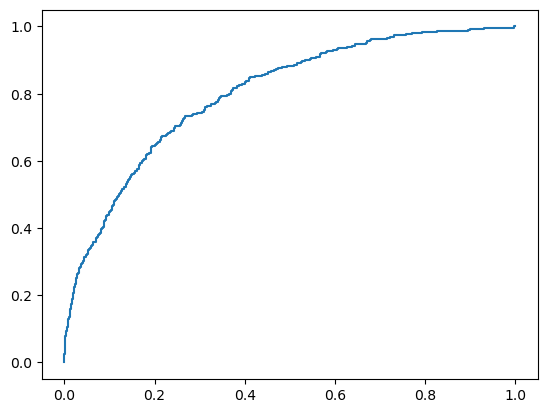

In [38]:
# 查看预测属于各个分类的概率
y_pred_proba = model.predict_proba(X_test)

# 绘制ROC曲线
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [39]:
# AUC值
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred_proba[:,1])
score

0.8013717738174887

如果把假警报率理解为代价的话，那么命中率就是收益，所以也可以说在相同阈值的情况下，我们希望假警报率（代价）尽量小的情况下，命中率（收益）尽量的高，该思想反映在图形上就是这个曲线尽可能的陡峭，曲线越靠近左上角说明在同样的阈值条件下，命中率越高，假警报率越小，模型越完善。换一个角度来理解，一个完美的模型是在不同的阈值下，假警报率(FPR)都接近于0，而命中率(TPR)接近于1，该特征反映在图形上，就是曲线非常接近（0，1）这个点，也即曲线非常陡峭。


在数值上，可以用**AUC值**来衡量模型的优劣。AUC值指曲线下面的面积，该面积的取值范围通常在0.5~1之间，0.5表示随机判断，1则表示完美的模型。
在商业实战中，因为存在很多扰动因子，AUC值能达到0.75以上就已经可以接受了，如果能够达到0.85以上，就是非常好的模型。

**评价模型的标准并不只有准确率和AUC，我们仍需关注精确度，召回率，F1分数。**

In [40]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score


# 准确率
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# 精确度
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# 召回率
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# F1分数
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# AUC分数
# 请确保y_pred_proba是指向正类的概率
auc = roc_auc_score(y_test, y_pred_proba[:, 1]) # 如果y_pred_proba是一维的，则去掉[:, 1]
print('AUC Score:', auc)


Accuracy: 0.9821396571292037
Precision: 0.5217391304347826
Recall: 0.04
F1 Score: 0.07430340557275542
AUC Score: 0.8013717738174887


1. **Accuracy (准确率)**: 
   这是模型正确预测的样本数占总样本数的比例。准确率高意味着模型在所有预测中得到了较多的正确结果。在这里，准确率为 98.21%，这意味着模型准确地预测了大部分的样本。

2. **Precision (精确率)**: 
   精确率是指模型预测为正类（如：欺诈）的样本中实际为正类的比例。在这里，精确率为 52.17%，意味着当模型预测一个样本为正类时，有大约一半的机会是正确的。

3. **Recall (召回率)**: 
   召回率是指在所有实际正类的样本中，模型成功预测为正类的比例。在这里，召回率为 4%，这意味着模型能够识别实际正类样本中很小的一部分。

4. **F1 Score (F1分数)**: 
   F1分数是精确率和召回率的调和平均数，取值范围为0到1。它试图同时考虑精确率和召回率。在精确率和召回率都很重要的情况下，F1分数是一个有用的指标。在这里，F1分数为 7.43%，这是一个相当低的值，表明模型在精确率和召回率方面的综合性能较差。

5. **AUC Score (ROC曲线下面积)**: 
   AUC 表示接收者操作特征曲线（ROC）下的面积，是模型将正类排在负类前面的能力的度量。AUC值的范围从0到1，值越大表示模型的性能越好。在这里，AUC分数为 80.14%，这意味着模型具有较好的区分正类和负类的能力。

综上所述，虽然这个模型的准确率很高，但这可能是因为数据集中负类（非欺诈）的样本数量远远多于正类（欺诈），因此模型通过主要预测最常见的类别就能获得高准确率。然而，模型的精确率和召回率都很低，特别是召回率只有4%，这表明模型没有很好地识别出正类样本。如果在实际应用中，比如欺诈检测，错过大量的正类（未检测到的欺诈）可能会带来严重后果，因此可能需要进一步调整模型以改善精确率和召回率，尤其是召回率。

### 随机欠样本抽样

随机欠采样（Random Undersampling）是一种处理不平衡数据集的技术。在不平衡数据集中，某个类别的样本数量远多于其他类别。随机欠采样的目标是通过随机地减少多数类（majority class）的样本数量来平衡类别分布

**显而易见的是，在本数据集中，有财务舞弊的公司远少于没有财务舞弊的公司，因此适用于随机欠样本抽样**

In [41]:
pip install imbalanced-learn

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [42]:
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier

# 初始化随机欠采样器
rus = RandomUnderSampler(random_state=42)

# 对数据集进行欠采样
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# 使用欠采样后的数据来训练LightGBM模型
model = LGBMClassifier()  
model.fit(X_resampled, y_resampled)

LGBMClassifier()

In [43]:
# 预测测试集数据
y_pred = model.predict(X_test)
print(y_pred)

[0. 0. 1. ... 0. 1. 0.]


In [44]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
score

0.7061704796607132

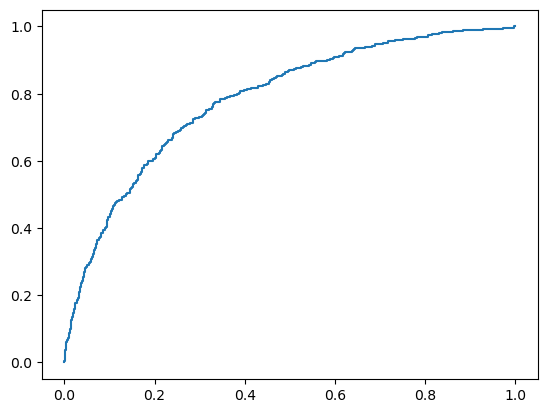

In [45]:
# 查看预测属于各个分类的概率
y_pred_proba = model.predict_proba(X_test)

# 绘制ROC曲线
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [46]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

# 准确率
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# 精确度
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# 召回率
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# F1分数
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# AUC分数
# 请确保y_pred_proba是指向正类的概率
auc = roc_auc_score(y_test, y_pred_proba[:, 1]) # 如果y_pred_proba是一维的，则去掉[:, 1]
print('AUC Score:', auc)


Accuracy: 0.7061704796607132
Precision: 0.04312561819980218
Recall: 0.7266666666666667
F1 Score: 0.08141923436041083
AUC Score: 0.7835518926261583


召回率的值域为 0 到 1（或者以百分比表示，从 0% 到 100%）。一个召回率为 1 或 100% 的模型能够识别所有真实的正类样本。召回率越高，意味着模型遗漏的正类越少。

### 特征重要性

In [47]:
features = X.columns  # 获取特征名称
importances = model.feature_importances_  # 获取特征重要性

# 通过二维表格形式显示
importances_df = pd.DataFrame()
importances_df['特征名称'] = features
importances_df['特征重要性'] = importances
importances_df.sort_values('特征重要性', ascending=False)

,特征名称,特征重要性
0,LargestHolderRate,415
6,F081901B,322
3,F031501A,309
5,F051901B,302
4,F051801B,298
1,F032501B,285
10,Fog,251
2,F032601B,223
9,EmotionIndex,221
7,F101201B,187


### 6.参数调优

LightGBM的各参数的调参范围参考经典文献 （Wang and Ni, 2020; Barnwal, Cho, and Hocking, 2020）：max_depth范围为6-20，num_leaves范围为40-4096，min_child_samples范围为18-22，min_child_weight范围为0.001-0.002，bagging_fraction范围为0.8-1，bagging_freq范围为2-5，reg_alpha范围为0.001-0.02，reg_lamda范围为2-8，learning_rate范围为0.005-0.02，num_iteration范围为200-500，按间距调整直到训练的模型召回率（Recall）最大为止。

In [48]:
# 重新搭建分类器
model = LGBMClassifier(bagging_fraction = 0.8, bagging_freq = 2, learning_rate = 0.01, max_depth = 10, min_child_samples = 20, min_child_weight = 0.001, n_estimators = 400, num_leaves = 40, reg_alpha = 0.01, reg_lambda = 2)
model.fit(X_resampled, y_resampled)

# 查看整体预测准确度
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print(score)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
0.7014515261931784


In [51]:
import pickle
import os

# 假设 model 是您要保存的模型
# model = ...

# 指定保存路径
folder_path = '/Users/tangyinbo/Documents/学习用/大三上/智能财务/个人作业/data'
filename = os.path.join(folder_path, 'saved_model.pkl')

# 保存模型
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"模型已保存到 {filename}")

模型已保存到 /Users/tangyinbo/Documents/学习用/大三上/智能财务/个人作业/data/saved_model.pkl


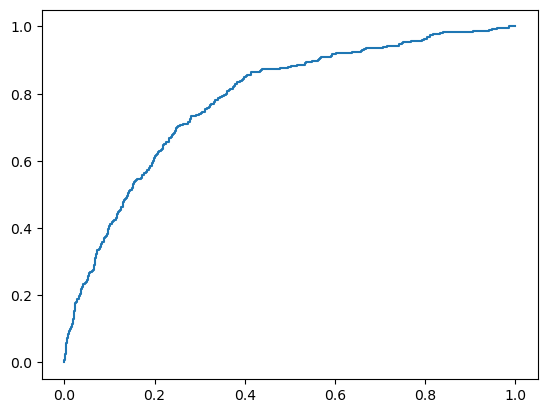

In [49]:
# 查看预测属于各个分类的概率
y_pred_proba = model.predict_proba(X_test)

# 绘制ROC曲线
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [50]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

# 准确率
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# 精确度
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# 召回率
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# F1分数
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# AUC分数
# 请确保y_pred_proba是指向正类的概率
auc = roc_auc_score(y_test, y_pred_proba[:, 1]) # 如果y_pred_proba是一维的，则去掉[:, 1]
print('AUC Score:', auc)


Accuracy: 0.7014515261931784
Precision: 0.043173862310385065
Recall: 0.74
F1 Score: 0.08158765159867695
AUC Score: 0.7841737120613101


1. **准确率 (Accuracy)**: 70.15%
   - 准确率较高，表明模型在整体上能够正确预测出大部分的样本。但是，这个指标可能会因为类别不平衡的问题而变得不那么可靠。如果负类样本远远多于正类样本，模型可能会倾向于预测最常见的类别，从而提高准确率。

2. **精确率 (Precision)**: 4.32%
   - 精确率非常低，意味着在模型预测为正类的案例中，很少有预测是正确的。这可能导致实际应用中的问题，因为这表明模型产生了大量的假阳性结果。

3. **召回率 (Recall)**: 74%
   - 召回率相对较高，说明模型能够捕捉到大多数实际正类的案例。这在那些遗漏正类后果严重的应用中是重要的，比如疾病筛查或欺诈检测。

4. **F1 Score**: 8.16%
   - F1分数是精确率和召回率的调和平均，它考虑到了二者的平衡。由于精确率极低，尽管召回率较高，F1分数仍然很低。这表明模型在识别正类时并不精确。

5. **AUC Score**: 78.42%
   - AUC分数较高，这表明模型在区分正负类别的能力上做得相对较好，因为AUC不受类别不平衡的影响。在不平衡数据集中，AUC是一个特别有用的性能度量。

从这些指标来看，模型似乎能够很好地识别正类（如通过召回率所示），但同时它在精确度上表现得很差，导致了很低的F1分数。这可能是因为模型对于实际为负的样本过于敏感，产生了过多的假阳性。但是在检测上市公司是否存在财务舞弊行为时，基于谨慎性原则，我们宁愿误伤好人（假阳性），也不愿意放过坏人（存在舞弊行为的上市公司），因此该模型可以应用于上市公司是否存在财务舞弊行为的检测中。


### 关于不同模型较低的Precision:

在实践中，如果模型的目标是最大限度地减少假阴性（例如，在欺诈检测或疾病筛查中），那么一个高召回率可能是可接受的，即使精确率较低。然而，如果错误的正类预测会带来高成本（比如发送不必要的营销材料给非目标客户），那么这个模型的表现可能是不可接受的。

根据这些性能指标，如果模型的目标是保持一个较高的召回率并且可以容忍一定量的假阳性，那么该模型可能仍然有用。

### 特征重要性

In [150]:
features = X.columns  # 获取特征名称
importances = model.feature_importances_  # 获取特征重要性

# 通过二维表格形式显示
importances_df = pd.DataFrame()
importances_df['特征名称'] = features
importances_df['特征重要性'] = importances
importances_df.sort_values('特征重要性', ascending=False)

,特征名称,特征重要性
0,LargestHolderRate,1788
6,F081901B,1494
5,F051901B,1428
1,F032501B,1328
4,F051801B,1254
3,F031501A,1173
9,EmotionIndex,1078
10,Fog,1032
2,F032601B,889
7,F101201B,845


可以看到，最大股东的持股比例是最重要的特征。基于信息不对称理论，本组提出两点猜想：

**1. 管理者与股东之间的对抗**
管理者有动力向外部所有者（股东）隐瞒内部消息。当股份被集中时，高份额股东会积极的参与到公司治理中；当股东权利被分散时，股东们缺乏积极性，这使得管理者有机可乘，进行财务舞弊行为，从而使自己获利。

例如：达到年度目标，从而获得奖金。

**2. 股东联合管理者与投资者之间的对抗**
当股东权利集中到一个人上时，他对于公司内部治理有着较大影响，从而可能指使管理者进行财务舞弊，使得自身获利。

例如：为了规避债务违约，进行盈余操控。

## XGboost模型

### 随机欠样本抽样

In [151]:
!pip install xgboost

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [152]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

# 初始化随机欠采样器
rus = RandomUnderSampler(random_state=42)

# 对数据集进行欠采样
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# 使用欠采样后的数据来训练XGboost模型
model = XGBClassifier()  # 或者使用通过GridSearchCV找到的最佳参数
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [153]:
# 预测测试集数据
y_pred = model.predict(X_test)
print(y_pred)

[0 0 1 ... 0 0 0]


In [154]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
score

0.6976883101367899

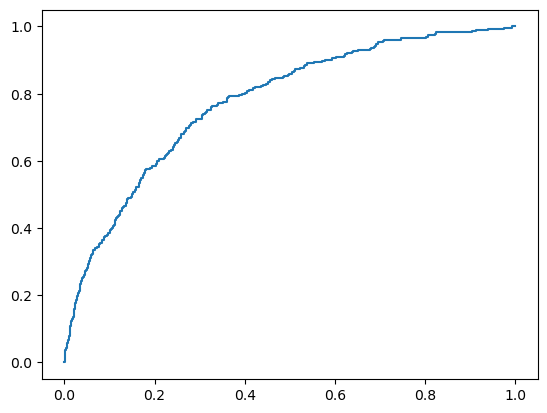

In [155]:
# 查看预测属于各个分类的概率
y_pred_proba = model.predict_proba(X_test)

# 绘制ROC曲线
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [156]:
# AUC值
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred_proba[:,1])
score

0.776376132838635

In [157]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

# 准确率
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# 精确度
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# 召回率
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# F1分数
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# AUC分数
# 请确保y_pred_proba是指向正类的概率
auc = roc_auc_score(y_test, y_pred_proba[:, 1]) # 如果y_pred_proba是一维的，则去掉[:, 1]
print('AUC Score:', auc)

Accuracy: 0.6976883101367899
Precision: 0.04177093358999037
Recall: 0.7233333333333334
F1 Score: 0.07898089171974522
AUC Score: 0.776376132838635


### 特征重要性

In [158]:
features = X.columns  # 获取特征名称
importances = model.feature_importances_  # 获取特征重要性

# 通过二维表格形式显示
importances_df = pd.DataFrame()
importances_df['特征名称'] = features
importances_df['特征重要性'] = importances
importances_df.sort_values('特征重要性', ascending=False)

,特征名称,特征重要性
7,F101201B,0.186138
5,F051901B,0.096908
0,LargestHolderRate,0.090765
10,Fog,0.089099
9,EmotionIndex,0.088676
4,F051801B,0.084351
1,F032501B,0.083009
3,F031501A,0.078787
6,F081901B,0.078763
8,InternalControlStrength,0.065462


### 参数调优

{'bagging_fraction': 0.8, 'bagging_freq': 2, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'n_estimators': 400, 'num_leaves': 40, 'reg_alpha': 0.01, 'reg_lambda': 2}

In [159]:
# 重新搭建分类器
model = XGBClassifier(max_depth = 10 , 
                      n_estimators = 400, 
                      learning_rate = 0.01,  
                      num_leaves = 40, 
                      reg_alpha = 0.01, 
                      reg_lambda = 2, 
                      bagging_fraction = 0.8, 
                      bagging_freq = 2, 
                      min_child_samples = 20, 
                      min_child_weight = 0.001)
model.fit(X_resampled, y_resampled)

# 查看整体预测准确度
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print(score)

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bagging_fraction", "bagging_freq", "min_child_samples", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


0.6877128009079505


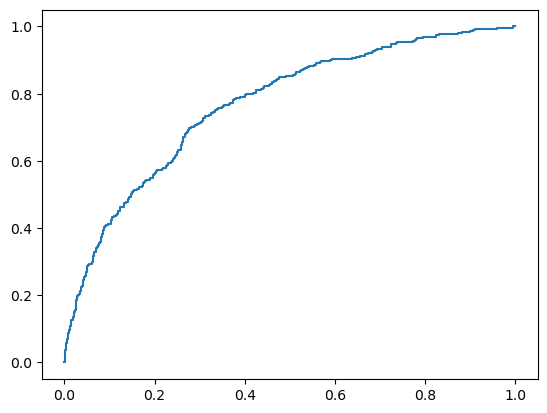

In [160]:
# 查看预测属于各个分类的概率
y_pred_proba = model.predict_proba(X_test)

# 绘制ROC曲线
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [162]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

# 准确率
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# 精确度
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# 召回率
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# F1分数
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# AUC分数
# 请确保y_pred_proba是指向正类的概率
auc = roc_auc_score(y_test, y_pred_proba[:, 1]) # 如果y_pred_proba是一维的，则去掉[:, 1]
print('AUC Score:', auc)

Accuracy: 0.6877128009079505
Precision: 0.040983606557377046
Recall: 0.7333333333333333
F1 Score: 0.07762879322512349
AUC Score: 0.7682472680088397


模型性能的提高不总是由单纯调整参数所保证的。参数的调整可能会在某些指标上导致性能提高，而在其他指标上导致性能下降。

- 准确率（Accuracy）从 69.77% 略微下降到 68.77%。
- 精确率（Precision）从 4.18% 略微下降到 4.10%。
- 召回率（Recall）从 72.33% 略微上升到 73.33%。
- F1分数（F1 Score）从 7.90% 略微下降到 7.76%。
- AUC分数（AUC Score）从 77.64% 略微下降到 76.82%。

性能表现出现下降可能有多种原因，以下是我们组找到的可能原因，包括：

1. **过拟合**：
   - 在第一次模型中，参数可能设置得更适合训练数据，但当应用到测试数据或未见数据时，模型可能无法保持同样的性能水平。调参后，如果模型变得更复杂，它可能在训练集上表现得更好，但在测试集上表现得更差，这是过拟合的一个典型迹象。

2. **参数选择**：
   - 某些参数可能不适合问题的特性，或者调整的方向不正确。例如，学习率可能设置得太高或太低，或者树的深度、叶子数量等参数设置得不合理。
    
3. **随机性**：
   - 训练算法中的随机性也可能导致性能的变化。例如，如果使用了随机梯度下降或初始化时的随机种子改变了，可能会影响结果。

## 模型比较

### LighGBM 与 XGBoost 比较

### 参考论文中的LightGBM 与本项目的LightGBM比较

在对比参考论文中的LightGBM模型与本项目中的LightGBM模型时，我们可以按照各个性能指标进行比较，并考虑可能的改进措施：

1. **准确率 (Accuracy)**:
   - 参考论文: 78.00%
   - 本项目: 70.15%
   本项目的准确率低于参考论文的准确率，说明在整体样本中，本项目的模型预测正确的比例较低。

2. **精确率 (Precision)**:
   - 参考论文: 6.00%
   - 本项目: 4.32%
   在预测为正类的案例中，本项目模型正确的比例也低于参考论文的模型。

3. **召回率 (Recall)**:
   - 参考论文: 74.80%
   - 本项目: 74.00%
   召回率几乎相同，**都能较好地识别出实际为正的样本。**

4. **F1 Score**:
   - 参考论文: 11.10%
   - 本项目: 8.16%
   F1分数在本项目中较低，表明精确率和召回率的平衡不如参考论文中的模型。

5. **AUC Score**:
   - 参考论文: 76.50%
   - 本项目: 78.42%
   AUC分数是本项目模型性能的亮点，比参考论文中的模型要高，表明在区分正负类别上本项目模型更加有效。

可能存在的原因有：

- **复杂度**:
  复杂词汇的定义不清晰，需要建立一个更准确的词汇表。同时，语法分析可以帮助进一步细化模型对于文本复杂度的理解。

- **情感分析**:
  情感词的分类不够细化，在未来可以利用或创建更为详细的情感词典，特别是针对年报这类特定文档的语言使用，这将有助于更准确地区分积极与消极情绪。

- **内控指标**:
  独立董事的参与度是一个重要因素，但其他因素，例如内控制度的完善性和内审的权重，同样重要。未来的模型可以考虑这些内控相关的其他因素，以提供一个更全面的内控质量评估。

- **年报数量**:
  后续数据检查中，发现有部分年报缺失，需要在未来补充相应数据，从而丰富实验数据，得到更加准确的模型

总体上，尽管对比参考论文的模型，本项目的模型在准确率和精确率上有待提高，**但仍能较好的识别上市公司的财务舞弊行为，因此在实际运用中，能够很好的帮助外部投资者识别潜在的财务违规风险**

## 结论

通过输入**2000-2023的财务数据和文本数据**，训练LightGBM和XGBoost模型，并比较它们在**准确率、精确率、召回率、F1分数和AUC分数**等关键性能指标上的表现后，我们发现**LightGBM的表现在所有的指标上都略胜一筹**。特别是，召回率和AUC分数显示LightGBM具有较强的检测能力，能够有效地检查出公司的舞弊情况。具体到数值上，LightGBM的召回率为74%，意味着它能够识别出74%的实际舞弊案例。而其AUC分数为78.42%，表明模型在区分舞弊与非舞弊公司上具有较好的性能。然而，在precession指标上的表现不良，可能的原因是正类数据较少（存在财务舞弊行为），不过在该实验下可以被接受的。

然而，与参考论文中的研究相比，我们的模型在准确率上未能达到相同水平（本项目的70.15%对比论文中的78%）。可能的原因包括：变量的定义和指标不明确，部分变量数据缺失等。

总而言之，尽管略逊于参考论文中的模型，本次项目的模型在识别财务舞弊行为上仍有较好的表现，可以被用于实际应用中，帮助外部投资者识别潜在的财务风险。

## 技术和经验总结

### 技术

**数据自动化处理、动态网络爬虫、文本情感分析、文本复杂度分析、机器学习、多线程工作**

### 经验

1. **使用多进程处理**可以显著提高下载和文本提取速度，但是无法在互动式编译器中使用，需要在Spyder或其他编译器中使用。本组在提取pdf的文本信息时，将处理时间从80h降低到16h。

2. **CSDN**是一个非常好的解决bug和其他问题的平台，在下载LightGBM时总是报错，在CSDN找到两行代码，成功下载。

3. **提前准备数据！提前准备数据！提前准备数据**！在确定好主题后，应在第一时间准备好数据，本小组低估了下载年报和从年报中提取文本的时间，导致中间有段时间较为仓促，但好在齐心协力使得项目即使完成。

4. **随机欠样本抽样**能够较好的解决样本不平衡问题，使模型在识别正分类的表现大幅提高。

## 参考文献